In [7]:
# Add PyDatAnalysis to path
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, "/Users/owensheekey/Documents/Research/PyDatAnalysis")

export_path = 'Exports/'


In [8]:
from __future__ import annotations
from progressbar import progressbar
from src.DatObject.Make_Dat import get_dat, get_dats
import src.UsefulFunctions as U
from src.DataStandardize.ExpSpecific.Feb21 import Feb21Exp2HDF, Feb21ExpConfig
from src.DataStandardize.ExpConfig import ExpConfigGroupDatAttribute, ExpConfigBase
import multiprocessing as mp
import plotly.graph_objs as go
import numpy as np
import lmfit as lm
from typing import TYPE_CHECKING, Iterable, Optional
from src.DatObject.Attributes.Transition import i_sense_digamma, i_sense, i_sense_digamma_quad
from src.UsefulFunctions import edit_params
from src.DatObject.Attributes.SquareEntropy import square_wave_time_array, integrate_entropy
import logging
logger = logging.getLogger(__name__)
import src.UsefulFunctions as U
from src.CoreUtil import decimate
import matplotlib.pyplot as plt
import numpy as np, scipy.stats as st

In [9]:
def narrow_fit(dat, width, **kwargs):
    '''
    Get a fit only including +/- width in dat.x around center of transition
    kwargs is the stuff to pass to get_fit
    Return a fit
    '''
    out = dat.SquareEntropy.get_Outputs(existing_only=True)
    x = np.copy(out.x)
    y = np.copy(out.averaged)
    y = np.mean(y[(0, 2), :], axis=0)

    start_ind = np.nanargmin(np.abs(np.add(x, width)))
    end_ind = np.nanargmin(np.abs(np.subtract(x, width)))

    x[:start_ind] = [np.nan] * start_ind
    x[end_ind:] = [np.nan] * (len(x) - end_ind)

    y[:start_ind] = [np.nan] * start_ind
    y[end_ind:] = [np.nan] * (len(y) - end_ind)

    fit = dat.SquareEntropy.get_fit(
        x=x,
        data=y,
        **kwargs)
    return fit

In [10]:
def narrow_fit_trans_only(dat, width, **kwargs):
    '''
    Get a fit only including +/- width in dat.x around center of transition
    kwargs is the stuff to pass to get_fit
    Return a fit
    '''
    x = np.copy(dat.Transition.avg_x)
    y = np.copy(dat.Transition.avg_data)

    start_ind = np.nanargmin(np.abs(np.add(x, width)))
    end_ind = np.nanargmin(np.abs(np.subtract(x, width)))

    x[:start_ind] = [np.nan] * start_ind
    x[end_ind:] = [np.nan] * (len(x) - end_ind)

    y[:start_ind] = [np.nan] * start_ind
    y[end_ind:] = [np.nan] * (len(y) - end_ind)

    fit = dat.SquareEntropy.get_fit(
        x=x,
        data=y,
        **kwargs)
    return fit

In [11]:
def do_calc(datnum, overwrite=True):
    """Just a function which can be passed to a process pool for faster calculation"""
    save_name = 'SPS.01'

    dat = get_dat(datnum)

    setpoints = [0.01, None]

    # Get other inputs
    setpoint_times = square_wave_time_array(dat.SquareEntropy.square_awg)
    sp_start, sp_fin = [U.get_data_index(setpoint_times, sp) for sp in setpoints]
    logger.debug(f'Setpoint times: {setpoints}, Setpoint indexs: {sp_start, sp_fin}')

    # Run Fits
    pp = dat.SquareEntropy.get_ProcessParams(name=None,  # Load default and modify from there
                                             setpoint_start=sp_start, setpoint_fin=sp_fin,
                                             transition_fit_func=i_sense,
                                             save_name=save_name)
    out = dat.SquareEntropy.get_Outputs(name=save_name, inputs=None, process_params=pp, overwrite=overwrite)
    dat.Entropy.get_fit(which='avg', name=save_name, data=out.average_entropy_signal, x=out.x, check_exists=False,
                        overwrite=overwrite)
    [dat.Entropy.get_fit(which='row', row=i, name=save_name,
                         data=row, x=out.x, check_exists=False,
                         overwrite=overwrite) for i, row in enumerate(out.entropy_signal)]
    return out

In [12]:
def get_deltaT(dat):
    """Returns deltaT of a given dat in mV"""
    ho1 = dat.AWG.max(0)  # 'HO1/10M' gives nA * 10
    t = dat.Logs.temps.mc

    # Datnums to search through (only thing that should be changed)
    datnums = set(range(2143, 2156))
    # datnums = set()
    # for j in range(5):
    #     datnums = datnums.union(set(range(28 * j + 1312, 28 * j + 1312 + 4 * 7 + 1)) - set([28 * j + 1312 + 4 * i for i in range(8)]))
    # datnums = list(datnums)

    dats = get_dats(datnums)

    dats = [d for d in dats if np.isclose(d.Logs.temps.mc, dat.Logs.temps.mc, rtol=0.1)]  # Get all dats where MC temp is within 10%
    bias_lookup = np.array([d.Logs.fds['HO1/10M'] for d in dats])

    indp = np.argmin(abs(bias_lookup - ho1))
    indm = np.argmin(abs(bias_lookup + ho1))
    theta_z = np.nanmean([d.Transition.avg_fit.best_values.theta for d in dats if d.Logs.fds['HO1/10M'] == 0])

    # temp_lookup = np.array([d.Logs.temps.mc for d in dats])
    # bias_lookup = np.array([d.Logs.fds['HO1/10M'] for d in dats])
    #
    # indp = np.argmin(temp_lookup - t + bias_lookup - ho1)
    # indm = np.argmin(temp_lookup - t + bias_lookup + ho1)
    # indz = np.argmin(temp_lookup - t + bias_lookup)

    theta_p = dats[indp].Transition.avg_fit.best_values.theta
    theta_m = dats[indm].Transition.avg_fit.best_values.theta
    # theta_z = dats[indz].Transition.avg_fit.best_values.theta
    return (theta_p + theta_m) / 2 - theta_z

In [17]:
# datnums = set(range(1869, 1919)) - set(range(1870, 1919, 2))
# transdatnums = set(range(1869, 1919)) - set(range(1869, 1919, 2))

# datnums = np.sort(list(set(range(2089, 2095)) - set(range(2090, 2095, 2))))
# transdatnums = np.sort(list(set(range(2089, 2095)) - set(range(2089, 2095, 2))))
# datnums = np.sort(list(set(range(1778, 1795))))

# datnums = np.sort(list(set(range(2156, 2162)) - set(range(2157, 2162, 2))))
# transdatnums = np.sort(list(set(range(2156, 2162)) - set(range(2156, 2162, 2))))

datnums = [2164,2167, 2170, 2176, 2160, 2131, 2178, 2180, 2182]
transdatnums = [2165,2168, 2171, 2177, 2161, 2132, 2179, 2181, 2183]

# datnums = np.sort(list(set(range(2095, 2143)) - set(range(2096, 2143, 2))))
# transdatnums = np.sort(list(set(range(2095, 2143)) - set(range(2095, 2143, 2))))
end = 2806
datnums = np.sort(list(set(range(2659, end)) - set(range(2660, end, 2)) - set([2793])))
transdatnums = np.sort(list(set(range(2659, end)) - set(range(2659, end, 2)) - set([2794])))
# datnums = np.array([2699, 2719, 2731, 2737, 2741, 2757])
# transdatnums = np.add(datnums, 1)
#datnums = np.sort(list(set(range(3066, 3255+1))))
datnums = np.sort(list(set(range(3451, 3551+1))))
#datnums = np.sort(list(set(range(3085, 3244+1)) | set(range(3430, 3450+1))))
#datnums = np.sort(list(set(range(3551, 3652+1))))
datnums = np.sort(list(set(range(3671, 3698+1))))
datnums = np.sort(list(set(range(3769, 3890+1))))
datnums = np.sort(list(set(range(3931, 3947+1))))
datnums = np.sort(list(set(range(3985, 4015+1))))
# datnums = np.sort(list(set(range(4017, 4047+1)) | set(range(4090, 4098+1))))
datnums = np.sort(list(set(range(4049, 4078+1)) | set(range(4099, 4106+1))))
# datnums = np.sort(list(set(range(4118, 4198+1))))
# datnums = np.sort(list(set(range(4238, 4318+1))))
# datnums = np.sort(list(set(range(4435, 4455+1))))
# datnums = np.sort(list(set(range(4468, 4494+1))))
# datnums = np.sort(list(set(range(4500, 4553+1))))
# # datnums = np.sort(list(set(range(4555, 4608+1))))
# # datnums = np.sort(list(set(range(4610, 4654+1))))
datnums = np.sort(list(set(range(4668, 4721+1))))
# datnums = np.sort(list(set(range(4723, 4776+1))))
# datnums = np.sort(list(set(range(4783, 4820+1))))
# datnums = np.sort(list(set(range(4847, 4882+1))))

In [18]:
dats = get_dats(list(datnums), overwrite=False)
# transdats = get_dats(list(transdatnums), overwrite=False) \\np.mean(dat.Data.sweepgates_x[1][1:])
ips = [np.mean(dat.Data.sweepgates_x[1][1:]) for dat in dats]

In [19]:
dats[0].Logs.fds

{'ACC*100': 69.887,
 'CSQ': -84.228,
 'ESC': -479.74,
 'ESP': -609.44,
 'HO1/10M': 0,
 'HO2*1000': 0,
 'IP1*2': 179.45,
 'IP1*200': -468.44}

In [20]:
out = [do_calc(dn, overwrite=False) for dn in progressbar(datnums)]

100% (54 of 54) |########################| Elapsed Time: 0:00:14 Time:  0:00:14


In [21]:
# Θ = np.average([dat.SquareEntropy.get_fit(which='avg',which_fit='transition', transition_part='cold', check_exists=False).best_values.theta for dat in progressbar(dats)])
fit = dats[0].SquareEntropy.get_fit(which='avg',which_fit='transition', transition_part='cold', check_exists=False)
Θ = 2.16
params = fit.params
params.add('g', value=0, vary=False, min=-50, max=1000)
new_pars = edit_params(params, param_name='theta', value=Θ, vary=False)
hot_pars = edit_params(params, param_name='theta', value=Θ, vary=True)

In [16]:
amp_digamma_ = [narrow_fit_trans_only(
    dat,
    500,
    which='avg', 
    initial_params=new_pars, 
    fit_func=i_sense_digamma, 
    check_exists=False).best_values.amp
for dat in progressbar(transdats)]

NameError: name 'transdats' is not defined

In [1341]:
g_digamma_ = [narrow_fit_trans_only(
    dat,
    500,
    initial_params=new_pars, 
    fit_func=i_sense_digamma, 
    check_exists=False).best_values.g
for dat in progressbar(transdats)]

100% (72 of 72) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


In [22]:
amp_digamma_cold = [narrow_fit(
    dat,
    500,
    initial_params=new_pars, 
    fit_func=i_sense_digamma, 
    check_exists=False).best_values.amp
for dat in progressbar(dats)]

100% (54 of 54) |########################| Elapsed Time: 0:00:04 Time:  0:00:04


In [23]:
mids_digamma_ = [narrow_fit(
    dat,
    500,
    initial_params=new_pars, 
    fit_func=i_sense_digamma, 
    check_exists=False).best_values.mid
for dat in progressbar(dats)]

100% (54 of 54) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


In [24]:
g_digamma_ = [narrow_fit(
    dat,
    500,
    initial_params=new_pars, 
    fit_func=i_sense_digamma, 
    check_exists=False).best_values.g
for dat in progressbar(dats)]

100% (54 of 54) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


In [684]:
deltaT = [dat.SquareEntropy.get_fit(which='avg', 
                                       which_fit='transition', 
                                       transition_part='hot',
                                       check_exists=False).best_values.theta
            - dat.SquareEntropy.get_fit(which='avg', 
                                       which_fit='transition', 
                                       transition_part='cold',
                                       check_exists=False).best_values.theta for dat in progressbar(dats)]

100% (38 of 38) |########################| Elapsed Time: 0:00:03 Time:  0:00:03


In [685]:
fig = go.Figure()

fig.add_trace(go.Scatter(mode='markers', x=ips, text=datnums, y=deltaT, name="Entropy fits"))

fig.update_layout(xaxis_title='IP1*200 /mV', yaxis_title='deltaT /mV',
                      title=f'Dats {dats[0].datnum} - {dats[-1].datnum}')
fig.show(renderer="browser")

In [669]:
np.mean(deltaT[0:10])

0.9594358912191719

In [671]:
st.t.interval(0.95, len(deltaT[0:10])-1, loc=np.mean(deltaT[0:10]), scale=st.sem(deltaT[0:10])) - np.mean(deltaT[0:10])

array([-0.01105639,  0.01105639])

In [ ]:
fig.write_html(f'Exports/dT_03_17_dats{datnums[0]}_{datnums[-1]}.html')

In [675]:
fig = go.Figure()

fig.add_trace(go.Scatter(mode='markers', x=ips, y=amp_digamma_cold, text=datnums, name="Transition fits"))

fig.update_layout(xaxis_title='IP1*200 /mV', yaxis_title='Amplitude /mV',
                      title=f'Dats {dats[0].datnum} - {dats[-1].datnum}')
fig.show(renderer="browser")

In [676]:
st.t.interval(0.95, len(amp_digamma_cold[0:10])-1, loc=np.mean(amp_digamma_cold[0:10]), scale=st.sem(amp_digamma_cold[0:10])) - np.mean(amp_digamma_cold[0:10])

array([-0.00114256,  0.00114256])

In [1153]:
fig.write_html(f'Exports/Ampl_03_17_dats{datnums[0]}_{datnums[-1]}.html')

In [222]:
fig = go.Figure()

fig.add_trace(go.Scatter(mode='markers', x=ips, y=g_digamma_, text=datnums, name="Transition fits"))

fig.update_layout(xaxis_title='IP1*200 /mV', yaxis_title='Gamma /mV',
                      title=f'Dats {dats[0].datnum} - {dats[-1].datnum}')
fig.show(renderer="browser")

In [614]:
fig = go.Figure()
for i, dat in progressbar(enumerate(dats)):
    x = dat.SquareEntropy.avg_x
    y = dat.SquareEntropy.default_Output.averaged
    ycold = np.mean(y[(0, 2), :], axis=0)
    yhot = np.mean(y[(1, 3), :], axis=0)
    xfit = np.linspace(-100,100,1001)
    fit = narrow_fit(
            dat,
            400,
            initial_params=new_pars, 
            fit_func=i_sense_digamma, 
            check_exists=False)
    yfit = fit.eval_fit(xfit) - fit.best_values.lin*xfit
#     fig.add_trace(go.Scatter(mode='markers', x=x, y=ycold - fit.best_values.lin*x, name=f'{datnums[i]}d_cold'))
#     fig.add_trace(go.Scatter(mode='markers', x=x, y=yhot - fit.best_values.lin*x, name=f'{datnums[i]}d_hot'))
    fig.add_trace(go.Scatter(mode='markers', x=x, y=y[0, :] - fit.best_values.lin*x, name=f'{datnums[i]}d_v0_0'))
    fig.add_trace(go.Scatter(mode='markers', x=x, y=y[1, :] - fit.best_values.lin*x, name=f'{datnums[i]}d_vp'))
    fig.add_trace(go.Scatter(mode='markers', x=x, y=y[2, :] - fit.best_values.lin*x, name=f'{datnums[i]}d_v_0_1'))
    fig.add_trace(go.Scatter(mode='markers', x=x, y=y[3, :] - fit.best_values.lin*x, name=f'{datnums[i]}d_vm'))
    fig.add_trace(go.Scatter(mode='lines', x=xfit, y=yfit, name=f'{datnums[i]}f', marker_color='grey'))
fig.update_layout(xaxis_title=dats[0].Logs.xlabel, yaxis_title='Current /nA',
                      title=f'Dat {dats[0].datnum} - {dats[-1].datnum}')
fig.show(renderer="browser")

| |                        #                         | 37 Elapsed Time: 0:00:02


In [85]:
fig.write_html(f'Exports/Cold_hot_transitions_plus_fit_dats{dats[0].datnum}_{dats[-1].datnum}.html')

In [45]:
ampl = [0.44 for dat in dats]
deltaT = [0.96 for dat in dats]
for i, dat in enumerate(dats):
    dat.Entropy.set_integration_info(dT=deltaT[i], amp=ampl[i], overwrite=True)

In [46]:
fig = go.Figure()
int_ents = []
int_ents_err = []
int_ents_peaks = []
for i in range(len(dats)):
    width = dat.Entropy.get_fit(which='avg', name="SPS.01", check_exists=True).best_values.theta*10
    center = dat.Entropy.get_fit(which='avg', name="SPS.01", check_exists=True).best_values.mid
    indstart = np.argmin(np.abs(np.subtract(out[i].x, center-width)))
    indstart2 = np.argmin(np.abs(np.subtract(out[i].x, center-1.5*width)))
    indend = np.argmin(np.abs(np.subtract(out[i].x, center+width)))
    indend2 = np.argmin(np.abs(np.subtract(out[i].x, center+1.5*width)))
    
    int_ent = integrate_entropy(out[i].average_entropy_signal, dats[i].Entropy.integration_info.sf)
    int_ents_peaks.append(max(int_ent))
    int_ents.append(int_ent[indend] - int_ent[indstart])
    err1 = st.t.interval(0.95, len(int_ent[indend:indend2])-1, loc=np.mean(int_ent[indend:indend2]), scale=st.sem(int_ent[indend:indend2]))[1] - int_ent[indend]
    err2 = int_ent[indstart] - st.t.interval(0.95, len(int_ent[indstart2:indstart])-1, loc=np.mean(int_ent[indstart2:indstart]), scale=st.sem(int_ent[indstart2:indstart]))[0]
    err3 = np.sqrt((0.011/0.96)**2 + (0.0011/0.44)**2)*(int_ent[indend] - int_ent[indstart])
    int_ents_err.append(np.sqrt(err1**2 + err2**2 + err3**2))
    
    
    fig.add_trace(go.Scatter(mode='markers', 
                             x=np.subtract(out[i].x, mids_digamma_[i]), 
                             y=int_ent,
                             text=f'Int Ent = {int_ents[i]:.2f}',
                             name= f'dat{dats[i].datnum}, IP*200:{dats[i].Logs.fds["IP1*200"]}, index{i}'))

fig.update_layout(xaxis_title=dats[0].Logs.xlabel, yaxis_title='Entropy /kb',
                      title=f'Dats {dats[0].datnum} - {dats[-1].datnum}')
fig.show(renderer='chrome')
print(width)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2023: RuntimeWarning:

invalid value encountered in multiply

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2024: RuntimeWarning:

invalid value encountered in multiply



29.138375678274265


In [287]:
fig.write_html(f'Exports/IntEntropy_03_22_dats{dats[0].datnum}_{dats[-1].datnum}.html')

In [47]:
ents = [dat.Entropy.get_fit(which='avg', name="SPS.01", check_exists=True).best_values.dS for dat in dats]
fig = go.Figure()
fig.add_trace(go.Scatter(mode='markers', 
                         x=ips, y=int_ents, 
                         text=datnums, 
                         name="Int",
                         marker=dict(color='LightSkyBlue',
                                     size=10,
                                     line=dict(color='DarkSlateGrey',
                                               width=2))))
fig.add_trace(go.Scatter(mode='markers', 
                         x=ips, y=ents, 
                         text=datnums, 
                         name="Fit",
                         marker=dict(color='Brown',
                                     size=10,
                                     line=dict(color='DarkSlateGrey',
                                               width=2))))
fig.add_trace(go.Scatter(mode='markers', 
                         x=ips, y=int_ents_peaks, 
                         text=datnums, 
                         name="Integrated Peak",
                         marker=dict(color='Green',
                                     size=10,
                                     line=dict(color='DarkSlateGrey',
                                               width=2))))


fig.update_layout(xaxis_title="IP1*200 /mV", yaxis_title='Entropy /kb',
                      title=f'Integrated -- Dats {dats[0].datnum} - {dats[-1].datnum}')
fig.show(renderer="chrome")

In [429]:
U.save_to_mat([int_ents, ents, np.divide(ips, 200)], ["integrated_dS", "fit_dS", "impurity_plunger"], 'Exports/Matlab/CapacitivelyCoupledDQD.mat')

In [430]:
shapes = ["^", "s", "*", "d", "P"]
colors = ["mediumseagreen", "slategrey", "indigo", "royalblue", "chocolate", 'cadetblue']
indexes = [30, 1, 8, 15, 22]#[4, 14, 26, 30]#[33, 0, 5, 16, 22]# [0,15,31]#[32,11, 28]#[0,16,28,41]#[0, 18, 25, 30, 33, 44]#
indexes_fit = [0, 1, 2, 3, 4]
slidenum = 1

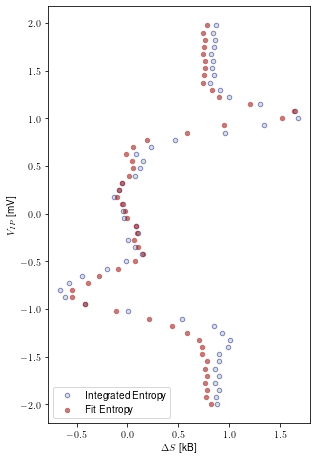

In [433]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})


plt.scatter(int_ents, np.divide(ips,200), marker="o", alpha=0.5, s=20, c='lightsteelblue', edgecolors="midnightblue", label='Integrated Entropy')
plt.scatter(ents, np.divide(ips,200), marker="o", alpha=0.5, s=20, c='maroon', edgecolors="firebrick", label='Fit Entropy')
plt.xlabel(r'$\Delta S$' + ' [kB]')
plt.ylabel(r'$V_{IP}$ [mV]')
plt.legend(loc='lower left')
fig = plt.gcf()
fig.set_size_inches(4.5, 6.5)
for idx in indexes_fit:
    clr = colors[idx]
    i = indexes[idx]
    plt.scatter(int_ents[i:i+1], np.divide(ips,200)[i:i+1], marker="d", alpha=1, s=100, c=clr, label=None)
plt.tight_layout()
#fig.savefig(f'Exports/presentation_03_29/slide{slidenum}_all_ent_v2.pdf', format='pdf')
#     plt.show()

In [61]:
theory = np.genfromtxt('Sent.csv',delimiter=',')
ent_theory = theory[:,-1][120:-100]
ent_theory_small_ut = theory[:,-2][120:-100]
eps_theory = np.subtract(-(2/15)*theory[:,0], 0.85)[120:-100]

In [51]:
len(eps_theory)

801

In [42]:
fig = go.Figure()

fig.add_trace(go.Scatter(mode='markers', x=eps_theory, y=ent_theory))

fig.show(renderer="chrome")

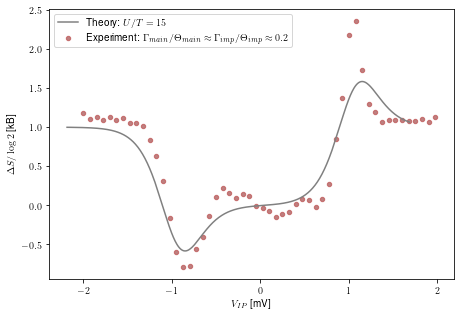

In [64]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})


#plt.scatter(np.divide(ips,200), np.divide(int_ents, np.log(2)), marker="o", alpha=0.5, s=20, c='lightsteelblue', edgecolors="midnightblue", label='Integrated Entropy')
plt.scatter(np.divide(ips,200), np.divide(ents, np.log(2)), marker="o", alpha=0.5, s=20, c='maroon', edgecolors="firebrick", label=r'Experiment: $\Gamma_{main}/\Theta_{main}\approx \Gamma_{imp}/\Theta_{imp} \approx 0.2$')
#plt.scatter(np.add(np.divide(ips,200),1), np.divide(ents, np.log(2)), marker="o", alpha=0.5, s=20, c='lightsteelblue', edgecolors="midnightblue", label=r'$\Gamma_{main}/\Theta_{main}\approx 0.2 \quad \Gamma_{imp}/\Theta_{imp} \approx 5$')
plt.plot(eps_theory, ent_theory, c='grey', label=r'Theory: $U/T = 15$')

plt.ylabel(r'$\Delta S/\log{2}$' + ' [kB]')
plt.xlabel(r'$V_{IP}$ [mV]')
plt.legend(loc='upper left')
fig = plt.gcf()
fig.set_size_inches(6.5, 4.5)
# for idx in indexes_fit:
#     clr = colors[idx]
#     i = indexes[idx]
#     plt.scatter(int_ents[i:i+1], np.divide(ips,200)[i:i+1], marker="d", alpha=1, s=100, c=clr, label=None)
plt.tight_layout()
fig.savefig(f'Exports/presentation_03_29/small_gamma_with_theory.pdf', format='pdf')

In [473]:
int_ents_temp = int_ents
ents_temp = ents
ips_temp = ips

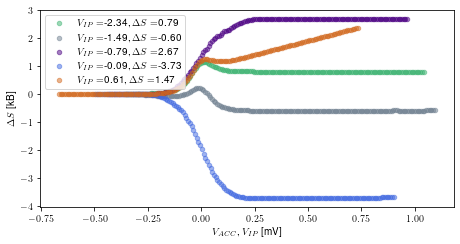

In [405]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
for clr, i in zip(colors, indexes):
    width = dat.Entropy.get_fit(which='avg', name="SPS.01", check_exists=True).best_values.theta*10
    center = dat.Entropy.get_fit(which='avg', name="SPS.01", check_exists=True).best_values.mid
    indstart = np.argmin(np.abs(np.subtract(out[i].x, center-width)))
    indend = np.argmin(np.abs(np.subtract(out[i].x, center+width)))
    int_ent = integrate_entropy(out[i].average_entropy_signal, dats[i].Entropy.integration_info.sf)
    label = r'$V_{IP} = $' + f'{dats[i].Logs.fds["IP1*200"]/200:.2f}, ' + r'$\Delta S = $' + f'{int_ent[indend] - int_ent[indstart]:.2f}' 
    plt.scatter(np.divide(np.subtract(out[i].x, mids_digamma_[i]),100), int_ent, marker="o", alpha=0.5, s=20, c=clr, label=label)
    
    
plt.ylabel(r'$\Delta S$' + ' [kB]')
plt.xlabel(r'$V_{ACC}$, $V_{IP}$ [mV]')
plt.legend(loc='upper left')
fig = plt.gcf()
fig.set_size_inches(6.5, 3.5)
plt.tight_layout()
fig.savefig(f'Exports/presentation_03_29/slide{slidenum}_int_ent_v2.pdf', format='pdf')

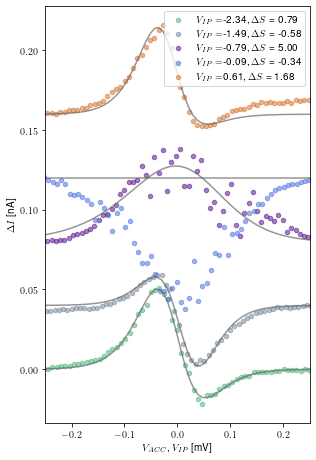

In [406]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
for j, idx in enumerate(indexes_fit):
    i = indexes[idx]
    clr = colors[idx]
    enty = out[i].average_entropy_signal
    entx = out[i].x
    fitent = dats[i].Entropy.get_fit(which='avg', name="SPS.01", check_exists=True).eval_fit(entx)
    ent = dats[i].Entropy.get_fit(which='avg', name="SPS.01", check_exists=True).best_values.dS
    
    plt.plot(entx/100, fitent + j*0.04, c='dimgrey', alpha=0.7, label=None)
    
    label = r'$V_{IP} = $' + f'{dats[i].Logs.fds["IP1*200"]/200:.2f}, ' + r'$\Delta S$ = ' + f'{ent:.2f}'
    plt.scatter(np.divide(entx,100), enty + j*0.04, marker="o", alpha=0.5, s=20, c=clr, label=label)
    
    
    
plt.ylabel(r'$\Delta I$' + ' [nA]')
plt.xlabel(r'$V_{ACC}$, $V_{IP}$ [mV]')
plt.legend(loc='upper right')
fig = plt.gcf()
plt.xlim((-0.25,0.25))
fig.set_size_inches(4.5, 6.5)
plt.tight_layout()
fig.savefig(f'Exports/presentation_03_29/slide{slidenum}_fit_ent_v2.pdf', format='pdf')

<ipython-input-695-aec27ed88311>:20: MatplotlibDeprecationWarning:

shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.



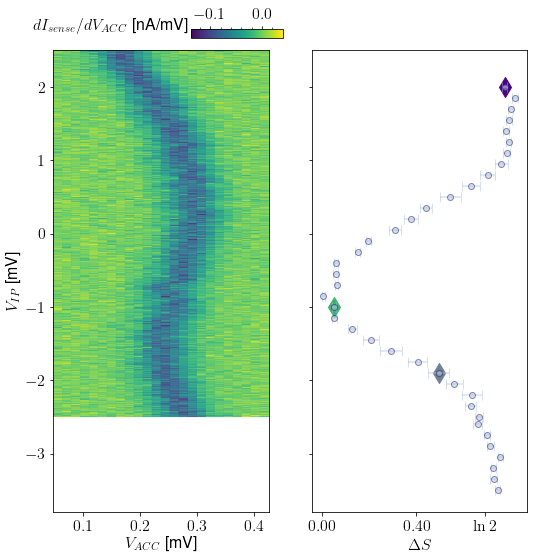

In [695]:
occ_data = get_dat(4782)
data = occ_data.Data.get_data('Experiment Copy/cscurrent_2d')
x=occ_data.Data.get_data('Experiment Copy/x_array')
y=occ_data.Data.get_data('Experiment Copy/y_array')


import matplotlib.pylab as pylab
import matplotlib.colors as colors
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 8),
         'axes.labelsize': 16,
         'axes.titlesize':20,
         'xtick.labelsize':16,
         'ytick.labelsize':16}
pylab.rcParams.update(params)

fig, a = plt.subplots(1,2, sharey=True)
ax = a[0]

im = ax.pcolor(np.divide(x[320:-290], 100), np.divide(y, 200), np.diff(data, axis=1)[:, 320:-290], edgecolors='face')
fig.set_size_inches(8.5, 8.5)
# Set X and Y labels
ax.set_xlabel(r'$V_{ACC}$ [mV]')
ax.set_ylabel(r'$V_{IP}$ [mV]')

# Set X and Y tick marks
# ax.set_xticks([0,50,90])
# ax.set_yticks([0,50,90])

# Use these 4 numbers to control [x-pos, y-pos, length, width] of the colorbar 
cax = fig.add_axes([.35, 0.90, 0.15, 0.015])
cb = fig.colorbar(im, cax=cax, orientation="horizontal")#, ticks=[0, 0.5, 1, 1.5])
cb.ax.xaxis.set_ticks_position('top')
# Add mini ticks
cb.minorticks_on()

# Name for color bar. Use "labelpad" to adjust location
cb.ax.set_ylabel(r'$dI_{sense}/dV_{ACC}$ [nA/mV]', rotation = 0, labelpad=80)

a[1].errorbar(int_ents, np.divide(ips,200), xerr=int_ents_err, marker="o",mec="midnightblue", c='lightsteelblue', alpha=0.5, fmt='o',capsize=5, label="Entropy")# size=20, , label=r'$\Gamma_{main}/\Theta_{main}\approx 0.2 \quad \Gamma_{imp}/\Theta_{imp} \approx 5$')
a[1].set_xlabel(r'$\Delta S$')
a[1].set_xticks([0, 0.4, 0.69])
fig.canvas.draw()
labels = [item.get_text() for item in a[1].get_xticklabels()]
labels[2] = r'$\ln 2$'
a[1].set_xticklabels(labels)

colors = ["slategrey", "mediumseagreen", "indigo", "royalblue", "chocolate", 'cadetblue']
indexes = [4, 10, 30]
indexes_fit = [0, 1, 2]
for idx in indexes_fit:
    clr = colors[idx]
    i = indexes[idx]
    a[1].scatter(int_ents[i:i+1], np.divide(ips,200)[i:i+1], marker="d", alpha=1, s=200, c=clr, label=None)


plt.savefig(f'Exports/thesis_presentation/entropy_along_highgamma_withmarkers.pdf', format='pdf')

In [ ]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
for j, idx in enumerate(indexes_fit):
    i = indexes[idx]
    clr = colors[idx]
    enty = out[i].average_entropy_signal
    entx = out[i].x
    fitent = dats[i].Entropy.get_fit(which='avg', name="SPS.01", check_exists=True).eval_fit(entx)
    ent = dats[i].Entropy.get_fit(which='avg', name="SPS.01", check_exists=True).best_values.dS
    
    plt.plot(entx/100, fitent + j*0.04, c='dimgrey', alpha=0.7, label=None)
    
    label = r'$\Delta S$ = ' + f'{ent:.2f}'
    plt.scatter(np.divide(entx,100), enty + j*0.04, marker="o", alpha=0.5, s=20, c=clr, label=label)
    
    
    
plt.ylabel(r'$\Delta I$' + ' [nA]')
plt.xlabel(r'$V_{ACC}$, $V_{IP}$ [mV]')
plt.legend(loc='upper right')
fig = plt.gcf()
plt.xlim((-0.25,0.25))
fig.set_size_inches(4.5, 8.5)
plt.tight_layout()
plt.savefig(f'Exports/thesis_presentation/dndt_highgamma.pdf', format='pdf')

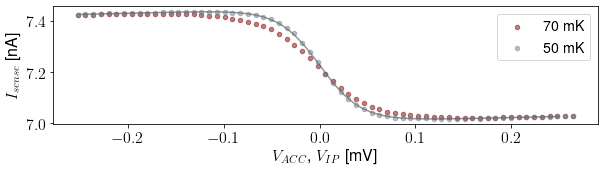

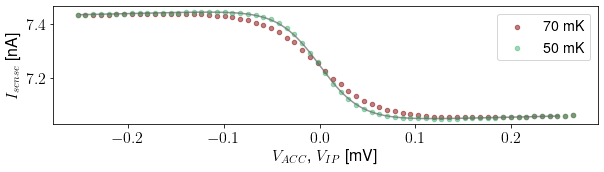

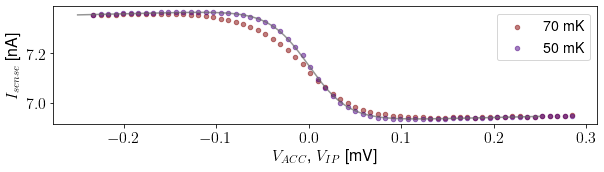

In [639]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
for j, idx in enumerate(indexes_fit):
    i = indexes[idx]
    clr = colors[idx]
    
    x = dats[i].SquareEntropy.avg_x
    y = dats[i].SquareEntropy.default_Output.averaged
    ycold = np.mean(y[(0, 2), :], axis=0)
    yhot = np.mean(y[(1, 3), :], axis=0)
    xfit = np.linspace(-25,25,1001)
    fit = narrow_fit(
            dats[i],
            400,
            initial_params=new_pars, 
            fit_func=i_sense_digamma, 
            check_exists=False)
    yfit = fit.eval_fit(xfit)
    plt.plot(xfit/100, yfit, c='dimgrey', alpha=0.7, label=None)
    plt.scatter(np.divide(x,100)[75:140], yhot[75:140], marker="o", alpha=0.5, s=20, c='maroon', label="70 mK")
    plt.scatter(np.divide(x,100)[75:140], ycold[75:140], marker="o", alpha=0.5, s=20, c=clr, label="50 mK")
    fig = plt.gcf()
    fig.set_size_inches(8.5, 2.5)
#     fig.add_trace(go.Scatter(mode='markers', x=x, y=ycold - fit.best_values.lin*x, name=f'{datnums[i]}d_cold'))
#     fig.add_trace(go.Scatter(mode='markers', x=x, y=yhot - fit.best_values.lin*x, name=f'{datnums[i]}d_hot'))
    plt.ylabel(r'$I_{sense}$' + ' [nA]')
    plt.xlabel(r'$V_{ACC}$, $V_{IP}$ [mV]')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'Exports/thesis_presentation/transition_highgamma_index{i}.pdf', format='pdf')
    plt.show()

In [407]:
centers = [dat.SquareEntropy.get_fit(data=dat.Data.get_data('Experiment Copy/cscurrent_2d')[0],
                                     name="Centers",
                                     x=dat.Data.get_data('Experiment Copy/x_array'),
                                     which_fit='transition', 
                                     check_exists=False).best_values.mid
for dat in progressbar(dats)]

100% (38 of 38) |########################| Elapsed Time: 0:00:03 Time:  0:00:03


In [408]:
occ_data = get_dat(dats[0].datnum-1)
data = occ_data.Data.get_data('Experiment Copy/cscurrent_2d')
x=occ_data.Data.get_data('Experiment Copy/x_array')
y=occ_data.Data.get_data('Experiment Copy/y_array')
accs = [dat.Logs.fds["ACC*100"] for dat in dats]

In [409]:
fig = go.Figure()
ips_other = np.array(ips)
fig.add_trace(go.Heatmap(
                    z=np.diff(data), x=np.divide(x[:-1],100), y=np.divide(y,200)))
fig.add_trace(go.Scatter(mode='markers', 
                         x=np.divide(centers,100), y=np.divide(ips_other,200), 
                         text=[dat.datnum for dat in dats],
                         marker_color="White"))
fig.update_layout(xaxis_title='Vacc /mV', yaxis_title='Vip /mV',
                      title=f'Differentiated conductance')
fig.show(renderer='chrome')

In [285]:
fig.write_html(f'Exports/IntEntropyvalues_03_24_dats{datnums[0]}_{datnums[-1]}.html')

In [261]:
fig = go.Figure()
fig.add_trace(go.Scatter(mode='markers', 
                         x=ips, y=np.subtract(int_ents_peaks,int_ents), 
                         text=datnums, 
                         name="Peak-Int",
                         marker=dict(color='Green',
                                     size=10,
                                     line=dict(color='DarkSlateGrey',
                                               width=2))))

fig.update_layout(xaxis_title='IP1*200 /mV', yaxis_title='Entropy /kb',
                      title=f'Integrated -- Dats {dats[0].datnum} - {dats[-1].datnum}')
fig.show(renderer="browser")

In [256]:
fig = go.Figure()
for i in range(len(dats)):
    enty = out[i].average_entropy_signal
    entx = out[i].x
    fitent = dats[i].Entropy.get_fit(which='avg', name="SPS.01", check_exists=True).eval_fit(entx)
    ent = dats[i].Entropy.get_fit(which='avg', name="SPS.01", check_exists=True).best_values.dS
    fig.add_trace(go.Scatter(mode='markers', 
                             x=entx,
                             y=enty,
                             name= f'dat{dats[i].datnum}, IP*200:{dats[i].Logs.fds["IP1*200"]}'))
    
    fig.add_trace(go.Scatter(mode='lines', x=entx, y=fitent, name=f'{datnums[i]}f, {ent}', marker_color='grey'))

fig.update_layout(xaxis_title=dats[0].Logs.xlabel, yaxis_title='Entropy /kb',
                      title=f'Dats {dats[0].datnum} - {dats[-1].datnum}')
fig.show(renderer='chrome')

In [194]:
fig.write_html(f'Exports/FitEntropy_03_23_dats{datnums[0]}_{datnums[-1]}.html')

In [331]:
centers = [dat.SquareEntropy.get_fit(data=dat.Data.get_data('Experiment Copy/cscurrent_2d')[0],
                                     name="Centers",
                                     x=dat.Data.get_data('Experiment Copy/x_array'),
                                     which_fit='transition', 
                                     check_exists=False).best_values.mid
for dat in progressbar(dats)]

100% (21 of 21) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


In [334]:
occ_data = get_dat(4846)
data = occ_data.Data.get_data('Experiment Copy/cscurrent_2d')
x=occ_data.Data.get_data('Experiment Copy/x_array')
y=occ_data.Data.get_data('Experiment Copy/y_array')
accs = [dat.Logs.fds["ACC*100"] for dat in dats]

In [335]:
fig = go.Figure()
ips_other = np.array(ips)
fig.add_trace(go.Heatmap(
                    z=np.diff(data), x=x[:-1], y=y))
fig.add_trace(go.Scatter(mode='markers', 
                         x=centers, y=ips_other, 
                         text=[dat.datnum for dat in dats],
                         marker_color="White"))
fig.update_layout(xaxis_title='ACC*100 /mV', yaxis_title='IP1*200',
                      title=f'Dats {dats[0].datnum} - {dats[-1].datnum}, dat{occ_data.datnum}')
fig.show(renderer='chrome')

In [291]:
fig.write_html(f'Exports/Along_occ_03_21_{dats[0].datnum}_{dats[-1].datnum}.html')

<ipython-input-662-dc25b4834479>:19: MatplotlibDeprecationWarning:

shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.



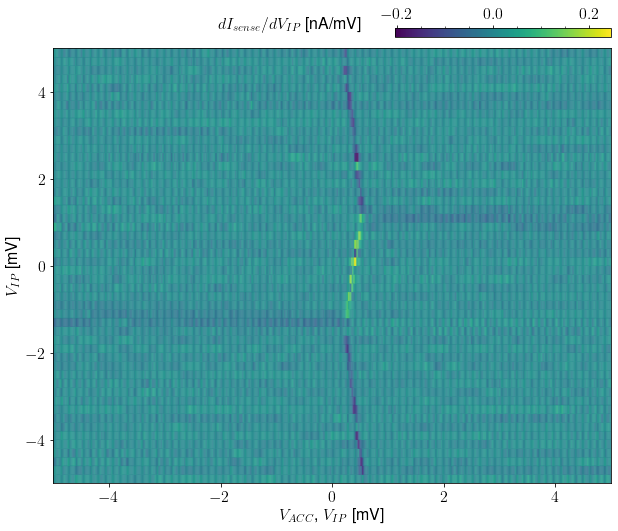

In [662]:
occ_data = get_dat(3060)
data = occ_data.Data.get_data('Experiment Copy/cscurrent_2d')
x=occ_data.Data.get_data('Experiment Copy/x_array')
y=occ_data.Data.get_data('Experiment Copy/y_array')


import matplotlib.pylab as pylab
import matplotlib.colors as colors
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 8),
         'axes.labelsize': 16,
         'axes.titlesize':20,
         'xtick.labelsize':16,
         'ytick.labelsize':16}
pylab.rcParams.update(params)

fig, ax = plt.subplots(1,1)

im = ax.pcolor(np.divide(np.subtract(x, np.mean(x)), 100), np.divide(np.subtract(y, np.mean(y)), 2), np.diff(data, axis=0), edgecolors='face')

# Set X and Y labels
ax.set_xlabel(r'$V_{ACC}$, $V_{IP}$ [mV]')
ax.set_ylabel(r'$V_{IP}$ [mV]')

# Set X and Y tick marks
# ax.set_xticks([0,50,90])
# ax.set_yticks([0,50,90])

# Use these 4 numbers to control [x-pos, y-pos, length, width] of the colorbar 
cax = fig.add_axes([.6, 0.90, 0.3, 0.015])
cb = fig.colorbar(im, cax=cax, orientation="horizontal")#, ticks=[0, 0.5, 1, 1.5])
cb.ax.xaxis.set_ticks_position('top')
# Add mini ticks
cb.minorticks_on()

# Name for color bar. Use "labelpad" to adjust location
cb.ax.set_ylabel(r'$dI_{sense}/dV_{IP}$ [nA/mV]', rotation = 0, labelpad=105)
plt.savefig(f'Exports/thesis_presentation/0to1_only_w_virtual.pdf', format='pdf')